# 0. Imports, Dataset, and Model

In [30]:
import os
from pathlib import Path
import pickle
from functools import partial

import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import matplotlib.pyplot as plt
import numpy as np

from rebayes.low_rank_filter.lofi import LoFiParams
from demos.showdown.classification import classification_train as benchmark
from demos.showdown.regression.peter import hparam_tune_reg as hpt
from rebayes.datasets import rotating_permuted_mnist_data as data_utils
from rebayes.datasets import classification_data as clf_data_utils

In [31]:
features = [500, 500, 1]
model_dict = benchmark.init_model(type='mlp', features=features, classification=False)
rmse_loss = lambda pred, target: jnp.sqrt(jnp.mean((pred - target)**2))

model, emission_mean_function = model_dict['model'], model_dict['emission_mean_function']

In [32]:
osa_callback = partial(
    benchmark.osa_eval_callback, 
    evaluate_fn=lambda pred, target: -rmse_loss(pred, target),
)

In [33]:
def optimize_agent(method, agent, pbounds, opt_init_points, opt_n_iter, exp_n_iter, config):
    dataset, data_load_fn = config["dataset"], config["data_load_fn"]
    ntrain_per_task, ntest_per_task = config["ntrain_per_task"], config["ntest_per_task"]
    optimizer, *_ = hpt.create_optimizer(
        model, pbounds, 0, dataset['train'], dataset['val'], callback=osa_callback, 
        method=method, verbose=2, callback_at_end=False, emission_mean_fn = emission_mean_function,
        **agent
    )
    optimizer.maximize(
        init_points=opt_init_points,
        n_iter=opt_n_iter,
    )
    
    best_hparams = hpt.get_best_params(optimizer, method=method)
    
    estimator = hpt.build_estimator(
        model_dict['flat_params'],
        model_dict['apply_fn'],
        best_hparams,
        method=method,
        **agent,
    )
    result = jax.block_until_ready(
        benchmark.nonstationary_mnist_eval_agent(
            data_load_fn,
            ntrain_per_task,
            ntest_per_task,
            model_dict['apply_fn'],
            estimator,
            n_iter=exp_n_iter,
            loss_fn=rmse_loss,
        )
    )
    
    return result

In [34]:
def plot_result(mean, std, n_iter, label, boundaries=None, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(mean, label=label)
    ax.fill_between(
        jnp.arange(len(mean)),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.3
    )
    if boundaries is not None:
        for b in boundaries:
            ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
        ax.set_xticks(boundaries)
    ax.set_xlabel("num. observations")
    if title is not None:
        ax.set_title(title)
    
    return ax

In [35]:
def plot_all_result(result, n_iter, label, boundaries=None):
    curr_mean, curr_std = result["current"], result["current-std"]
    curr_title = "Rotating Permuted Fashion MNIST - Current Task Performance"
    plot_result(curr_mean, curr_std, n_iter, label, boundaries, title=curr_title);
    
    first_mean, first_std = result["first_task"], result["first_task-std"]
    first_title = "Rotating Permuted Fashion MNIST - First Task Performance"
    plot_result(first_mean, first_std, n_iter, label, boundaries, title=first_title);
    
    cum_mean, cum_std = result["overall"], result["overall-std"]
    cum_title = "Rotating Permuted Fashion MNIST - Cumulative Task Performance"
    plot_result(cum_mean, cum_std, n_iter, label, boundaries, title=cum_title);
    

# 1. Stationary Regression (Sanity Check)

## 1.0. Dataset

In [36]:
n_train, n_val, n_test = 6_000, 1, 1_000
n_tasks = 10
ntrain_per_task, nval_per_task, ntest_per_task = (n//n_tasks for n in (n_train, n_val, n_test))

stationary_data_kwargs = {
    'n_tasks': n_tasks,
    'ntrain_per_task': ntrain_per_task,
    'nval_per_task': nval_per_task,
    'ntest_per_task': ntest_per_task,
}

mnist_dataset = clf_data_utils.load_mnist_dataset(n_train=n_train, n_val=n_val, n_test=n_test)
stationary_dataset = data_utils.generate_rotating_permuted_mnist_regression_dataset(
    **stationary_data_kwargs, mnist_dataset=mnist_dataset,
)

In [37]:
stationary_dataset_load_fn = partial(
    data_utils.generate_rotating_permuted_mnist_regression_dataset,
    **stationary_data_kwargs, mnist_dataset=mnist_dataset,
)

## 1.1 RSGD (SGD)

In [38]:
st_sgd_10_agent = {
    'loss_fn': rmse_loss,
    'buffer_size': 10,
    'dim_output': 1,
    "optimizer": "sgd",
}

st_sgd_pbounds = {
    'log_learning_rate': (-6.0, 0.0),
}

init_points, n_iter = 10, 15

In [39]:
agent_type = 'sgd-rb-10'

st_sgd_10_optimizer, *_ = hpt.create_optimizer(
    model, st_sgd_pbounds, 0, stationary_dataset['train'], stationary_dataset['val'], callback=osa_callback, 
    method='sgd-rb-10', verbose=2, callback_at_end=False, emission_mean_fn = emission_mean_function,
    **st_sgd_10_agent
)
init_points, n_iter = 10, 15

In [40]:
st_sgd_10_optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)

|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -33.73    | -2.707    |
| 2         | -48.1     | -1.709    |
| 3         | -36.67    | -2.383    |
| 4         | -33.17    | -2.731    |
| 5         | -26.12    | -3.458    |
| 6         | -40.14    | -2.125    |
| 7         | -26.81    | -3.374    |
| 8         | -1e+06    | -0.6494   |
| 9         | -1e+06    | -0.218    |
| 10        | -25.51    | -3.699    |
| 11        | -26.66    | -6.0      |
| 12        | -25.75    | -4.995    |
| 13        | -26.03    | -4.427    |
| 14        | -26.15    | -5.542    |
| 15        | -25.6     | -4.098    |
| 16        | -25.9     | -5.269    |
| 17        | -44.97    | -1.877    |
| 18        | -25.86    | -4.706    |
| 19        | -26.22    | -5.804    |
| 20        | -29.38    | -3.06     |
| 21        | -25.46    | -3.907    |
| 22        | -25.86    | -4.269    |
| 23        | -25.77    | -4.851    |
| 24        | -31.45    | -2.913    |
| 25        

In [41]:
st_sgd_10_best_hparams = hpt.get_best_params(st_sgd_10_optimizer, method="sgd-rb-10")

In [42]:
st_sgd_10_estimator = hpt.build_estimator(
    model_dict['flat_params'],
    model_dict['apply_fn'],
    st_sgd_10_best_hparams,
    method=agent_type,
    emission_mean_function=emission_mean_function,
    **st_sgd_10_agent,
)

In [43]:
st_sgd_10_result = jax.block_until_ready(
    benchmark.nonstationary_mnist_eval_agent(
        stationary_dataset_load_fn,
        ntrain_per_task,
        ntest_per_task,
        model_dict['apply_fn'],
        st_sgd_10_estimator,
        n_iter=1,
        loss_fn=rmse_loss,
    )
)

Evaluating agent...: 100%|██████████| 1/1 [00:32<00:00, 32.12s/it]


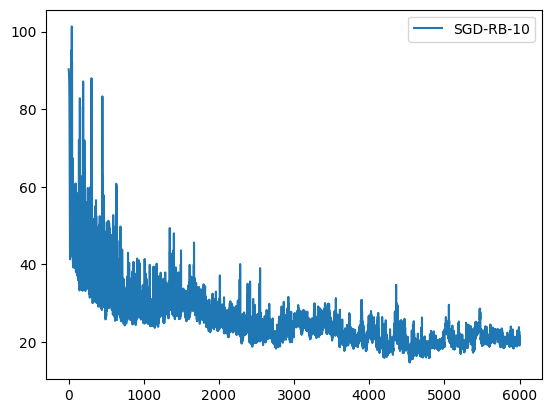

In [44]:
st_sgd_10_curr_mean, st_sgd_10_curr_std = st_sgd_10_result['current'], st_sgd_10_result['current-std']
fig, ax = plt.subplots()
ax.plot(st_sgd_10_curr_mean, label='SGD-RB-10')
ax.fill_between(
    jnp.arange(len(st_sgd_10_curr_mean)), 
    st_sgd_10_curr_mean - st_sgd_10_curr_std,
    st_sgd_10_curr_mean + st_sgd_10_curr_std,
    alpha=0.3
)
ax.legend();

## 1.2 RSGD (Adam)

In [45]:
st_adam_10_agent = {
    'loss_fn': rmse_loss,
    'buffer_size': 10,
    'dim_output': 1,
    "optimizer": "adam",
}

st_adam_pbounds = {
    'log_learning_rate': (-8.0, 0.0),
}

init_points, n_iter = 10, 15

In [46]:
st_adam_10_optimizer, *_ = hpt.create_optimizer(
    model, st_sgd_pbounds, 0, stationary_dataset['train'], stationary_dataset['val'], callback=osa_callback, 
    method="sgd-rb-10", verbose=2, callback_at_end=False, emission_mean_fn = emission_mean_function,
    **st_adam_10_agent
)
init_points, n_iter = 10, 15

In [47]:
st_adam_10_optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)

|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -31.69    | -2.707    |
| 2         | -35.59    | -1.709    |
| 3         | -33.24    | -2.383    |
| 4         | -32.22    | -2.731    |
| 5         | -31.42    | -3.458    |
| 6         | -33.89    | -2.125    |


KeyboardInterrupt: 

In [ ]:
st_adam_10_best_hparams = hpt.get_best_params(st_adam_10_optimizer, method="sgd-rb-10")

In [ ]:
st_adam_10_estimator = hpt.build_estimator(
    model_dict['flat_params'],
    model_dict['apply_fn'],
    st_adam_10_best_hparams,
    method="sgd-rb-10",
    emission_mean_function=emission_mean_function,
    **st_adam_10_agent,
)

In [ ]:
st_adam_10_result = jax.block_until_ready(
    benchmark.nonstationary_mnist_eval_agent(
        stationary_dataset_load_fn,
        ntrain_per_task,
        ntest_per_task,
        model_dict['apply_fn'],
        st_adam_10_estimator,
        n_iter=1,
        loss_fn=rmse_loss,
    )
)

Evaluating agent...: 100%|██████████| 1/1 [00:29<00:00, 29.84s/it]


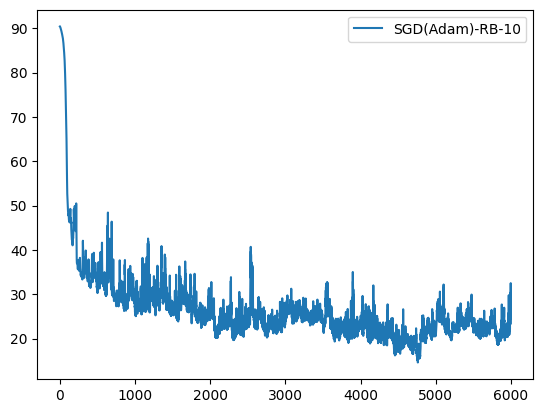

In [ ]:
st_adam_10_curr_mean, st_adam_10_curr_std = st_adam_10_result['current'], st_adam_10_result['current-std']
fig, ax = plt.subplots()
ax.plot(st_adam_10_curr_mean, label='SGD(Adam)-RB-10')
ax.fill_between(
    jnp.arange(len(st_adam_10_curr_mean)), 
    st_adam_10_curr_mean - st_adam_10_curr_std,
    st_adam_10_curr_mean + st_adam_10_curr_std,
    alpha=0.3
)
ax.legend();

## 1.3. LOFI (Let BayesOpt Choose Dynamics)

In [ ]:
st_lofi_10_agents = {
    'memory_size': 10,
    'inflation': "hybrid",
}

st_lofi_10_pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-40, 0),
    'log_dynamics_cov': (-40, 0),
    'log_emission_cov': (-40, 0),
    'log_alpha': (-40, 0),
}

init_points, n_iter = 20, 25

In [ ]:
st_lofi_10_optimizer, *_ = hpt.create_optimizer(
    model, st_lofi_10_pbounds, 0, stationary_dataset['train'], stationary_dataset['val'],
    callback=osa_callback, method='lofi-10', verbose=2,
    callback_at_end=False, emission_mean_fn=emission_mean_function, **st_lofi_10_agents,
)
init_points, n_iter = 20, 25

In [ ]:
st_lofi_10_optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------------------
| 1         | -1e+08    | -18.05    | -11.39    | -15.89    | -18.2     | -5.763    |
| 2         | -89.44    | -14.16    | -22.5     | -4.329    | -1.453    | -6.166    |
| 3         | -24.88    | -8.331    | -18.84    | -17.28    | -2.976    | -9.29     |
| 4         | -1e+08    | -36.51    | -39.19    | -6.695    | -8.874    | -1.3      |
| 5         | -9.99e+07 | -0.8553   | -8.034    | -21.54    | -8.779    | -8.817    |
| 6         | -1e+08    | -14.4     | -34.27    | -2.213    | -19.13    | -5.853    |
| 7         | -9.997e+0 | -29.42    | -9.031    | -21.75    | -17.26    | -9.812    |
| 8         | -25.31    | -15.29    | -15.52    | -15.32    | -2.25     | -3.182    |
| 9         | -1e+08    | -25.62    | -22.52    | -12.09    | -37.59    | -3.332    |
| 10        | -1e+08    | -13.17    | -31.58    | -34.

In [ ]:
st_lofi_10_best_hparams = hpt.get_best_params(st_lofi_10_optimizer, method="lofi-10")

In [ ]:
st_lofi_10_estimator = hpt.build_estimator(
    model_dict['flat_params'],
    model_dict['apply_fn'],
    st_lofi_10_best_hparams,
    method="lofi-10",
    **st_lofi_10_agents,
)

In [ ]:
st_lofi_10_result = jax.block_until_ready(
    benchmark.nonstationary_mnist_eval_agent(
        stationary_dataset_load_fn,
        ntrain_per_task,
        ntest_per_task,
        model_dict['apply_fn'],
        st_lofi_10_estimator,
        n_iter=1,
        loss_fn=rmse_loss,
    )
)

Evaluating agent...: 100%|██████████| 1/1 [01:00<00:00, 60.87s/it]


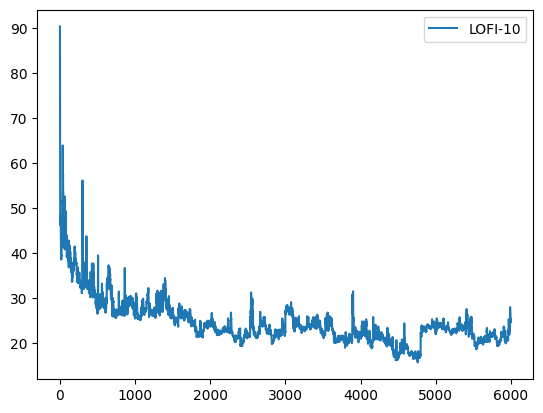

In [ ]:
st_lofi_10_curr_mean, st_lofi_10_curr_std = st_lofi_10_result['current'], st_lofi_10_result['current-std']
fig, ax = plt.subplots()
ax.plot(st_lofi_10_curr_mean, label='LOFI-10')
ax.fill_between(
    jnp.arange(len(st_lofi_10_curr_mean)), 
    st_lofi_10_curr_mean - st_lofi_10_curr_std,
    st_lofi_10_curr_mean + st_lofi_10_curr_std,
    alpha=0.3
)
ax.legend();

## 1.5 LOFI (Dynamics Fixed)

In [ ]:
st_lofi_10_agents = {
    'memory_size': 10,
    'inflation': "hybrid",
}

st_fd_lofi_10_pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-90, -90),
    'log_emission_cov': (-40, 0),
    'log_alpha': (-40, 0),
}

init_points, n_iter = 20, 25

In [ ]:
st_fd_lofi_10_optimizer, *_ = hpt.create_optimizer(
    model, st_fd_lofi_10_pbounds, 0, stationary_dataset['train'], stationary_dataset['val'],
    callback=osa_callback, method='lofi-10', verbose=2,
    callback_at_end=False, emission_mean_fn=emission_mean_function, **st_lofi_10_agents,
)
init_points, n_iter = 20, 25

In [ ]:
st_fd_lofi_10_optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------------------
| 1         | -1e+08    | -18.05    | -90.0     | -90.0     | -18.2     | -5.763    |
| 2         | -25.63    | -14.16    | -90.0     | -90.0     | -1.453    | -6.166    |
| 3         | -24.81    | -8.331    | -90.0     | -90.0     | -2.976    | -9.29     |
| 4         | -1e+08    | -36.51    | -90.0     | -90.0     | -8.874    | -1.3      |
| 5         | -1e+08    | -0.8553   | -90.0     | -90.0     | -8.779    | -8.817    |
| 6         | -1e+08    | -14.4     | -90.0     | -90.0     | -19.13    | -5.853    |
| 7         | -1e+08    | -29.42    | -90.0     | -90.0     | -17.26    | -9.812    |
| 8         | -23.92    | -15.29    | -90.0     | -90.0     | -2.25     | -3.182    |
| 9         | -1e+08    | -25.62    | -90.0     | -90.0     | -37.59    | -3.332    |
| 10        | -1e+08    | -13.17    | -90.0     | -90.

In [ ]:
st_fd_lofi_10_best_hparams = hpt.get_best_params(st_fd_lofi_10_optimizer, method="lofi-10")

In [ ]:
st_fd_lofi_10_estimator = hpt.build_estimator(
    model_dict['flat_params'],
    model_dict['apply_fn'],
    st_fd_lofi_10_best_hparams,
    method="lofi-10",
    **st_lofi_10_agents,
)

In [ ]:
st_fd_lofi_10_result = jax.block_until_ready(
    benchmark.nonstationary_mnist_eval_agent(
        stationary_dataset_load_fn,
        ntrain_per_task,
        ntest_per_task,
        model_dict['apply_fn'],
        st_fd_lofi_10_estimator,
        n_iter=1,
        loss_fn=rmse_loss,
    )
)

Evaluating agent...: 100%|██████████| 1/1 [01:05<00:00, 65.02s/it]


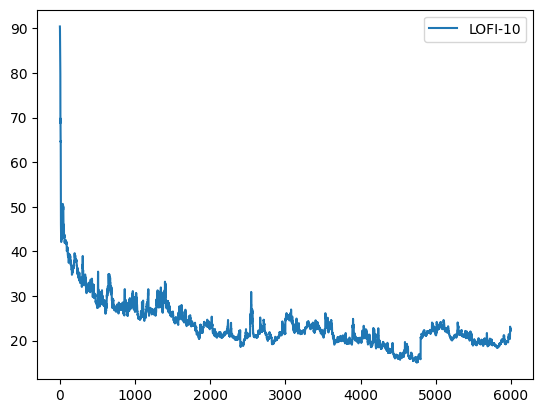

In [ ]:
st_fd_lofi_10_curr_mean, st_fd_lofi_10_curr_std = \
    st_fd_lofi_10_result['current'], st_fd_lofi_10_result['current-std']
fig, ax = plt.subplots()
ax.plot(st_fd_lofi_10_curr_mean, label='LOFI-10')
ax.fill_between(
    jnp.arange(len(st_fd_lofi_10_curr_mean)), 
    st_fd_lofi_10_curr_mean - st_fd_lofi_10_curr_std,
    st_fd_lofi_10_curr_mean + st_fd_lofi_10_curr_std,
    alpha=0.3
)
ax.legend();

## 1.6 Method Comparison

In [ ]:
# Load results from pickle
output_path = Path(Path().cwd(), "results", "stationary_reg")
st_sgd_10_curr_mean = pickle.load(open(Path(output_path, "SGD-10_mean.pkl"), "rb"))
st_sgd_10_curr_std = pickle.load(open(Path(output_path, "SGD-10_std.pkl"), "rb"))
st_adam_10_curr_mean = pickle.load(open(Path(output_path, "Adam-10_mean.pkl"), "rb"))
st_adam_10_curr_std = pickle.load(open(Path(output_path, "Adam-10_std.pkl"), "rb"))
st_lofi_10_curr_mean = pickle.load(open(Path(output_path, "LOFI-10_mean.pkl"), "rb"))
st_lofi_10_curr_std = pickle.load(open(Path(output_path, "LOFI-10_std.pkl"), "rb"))
st_fd_lofi_10_curr_mean = pickle.load(open(Path(output_path, "LOFI-10-Fixed-Dynamics_mean.pkl"), "rb"))
st_fd_lofi_10_curr_std = pickle.load(open(Path(output_path, "LOFI-10-Fixed-Dynamics_std.pkl"), "rb"))

In [ ]:
results = {
    "SGD-10": (st_sgd_10_curr_mean, st_sgd_10_curr_std),
    "Adam-10": (st_adam_10_curr_mean, st_adam_10_curr_std),
    "LOFI-10": (st_lofi_10_curr_mean, st_lofi_10_curr_std),
    "LOFI-10-Fixed-Dynamics": (st_fd_lofi_10_curr_mean, st_fd_lofi_10_curr_std),
}

In [ ]:
# # Save results to pickle
# output_path = Path(Path().cwd(), "results", "stationary_reg")
# output_path.mkdir(parents=True, exist_ok=True)

# for k, v in results.items():
#     mean, std = v
#     with open(Path(output_path, f"{k}_mean.pkl"), "wb") as f:
#         pickle.dump(mean, f)
#     with open(Path(output_path, f"{k}_std.pkl"), "wb") as f:
#         pickle.dump(std, f)

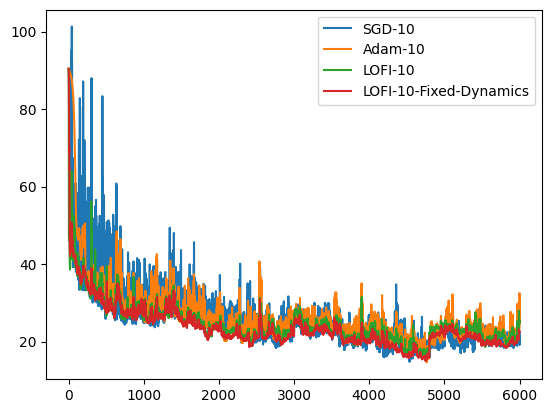

In [ ]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(val[0], label=key)
    ax.fill_between(
        jnp.arange(len(val[0])), 
        val[0] - val[1],
        val[0] + val[1],
        alpha=0.3
    )
ax.legend();

# 2. Nonstationary Regression (300 per task)

## 2.0 Dataset

In [ ]:
nst_300_data_kwargs = {
    'n_tasks': 10,
    'ntrain_per_task': 300,
    'nval_per_task': 1,
    'ntest_per_task': 1_000,
}
nst_300_dataset = data_utils.generate_rotating_permuted_mnist_regression_dataset(**nst_300_data_kwargs)
nst_300_dataset_load_fn = partial(data_utils.generate_rotating_permuted_mnist_regression_dataset, 
                                  **nst_300_data_kwargs, fashion=True)

2023-04-27 17:12:52.389601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-04-27 17:12:52.389645: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
osa_ll_callback = partial(
    benchmark.osa_eval_callback, 
    evaluate_fn=lambda pred, target: -rmse_loss(pred, target),
)

In [ ]:
nt, npt = nst_300_data_kwargs["n_tasks"], nst_300_data_kwargs["ntrain_per_task"]

nst_300_boundaries = [i for i in range(npt, (npt*nt)+1, npt)]

In [ ]:
nst_300_config = {
    "dataset": nst_300_dataset,
    "data_load_fn": nst_300_dataset_load_fn,
    "ntrain_per_task": nst_300_data_kwargs['ntrain_per_task'],
    "ntest_per_task": nst_300_data_kwargs['ntest_per_task'],
}

## 2.1 OGD (SGD)

In [ ]:
nst_300_sgd_1_agent = {
    'loss_fn': rmse_loss,
    'buffer_size': 1,
    'dim_output': 1,
    "optimizer": "sgd",
}

sgd_pbounds = {
    'log_learning_rate': (-8.0, 0.0),
}

init_points, n_iter = 10, 15
exp_n_iter = 5

In [ ]:
nst_300_sgd_1_result = optimize_agent("sgd-rb-1", nst_300_sgd_1_agent, sgd_pbounds, 
                                      init_points, n_iter, exp_n_iter, nst_300_config)

|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -54.88    | -3.609    |
| 2         | -136.0    | -2.278    |
| 3         | -57.46    | -3.178    |
| 4         | -54.35    | -3.641    |
| 5         | -46.2     | -4.611    |
| 6         | -55.55    | -2.833    |
| 7         | -46.55    | -4.499    |
| 8         | -1e+06    | -0.8658   |
| 9         | -1e+06    | -0.2907   |
| 10        | -44.03    | -4.932    |
| 11        | -58.45    | -8.0      |
| 12        | -44.92    | -6.66     |
| 13        | -42.12    | -5.903    |
| 14        | -53.14    | -7.389    |
| 15        | -42.43    | -5.463    |
| 16        | -48.49    | -7.025    |
| 17        | -54.65    | -2.502    |
| 18        | -43.44    | -6.274    |
| 19        | -56.3     | -7.739    |
| 20        | -50.95    | -4.08     |
| 21        | -43.0     | -5.21     |
| 22        | -41.98    | -5.692    |
| 23        | -43.94    | -6.469    |
| 24        | -52.74    | -3.884    |
| 25        

Evaluating agent...: 100%|██████████| 5/5 [05:29<00:00, 65.81s/it]


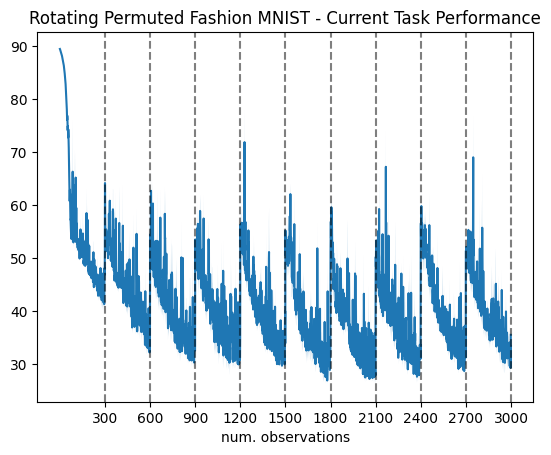

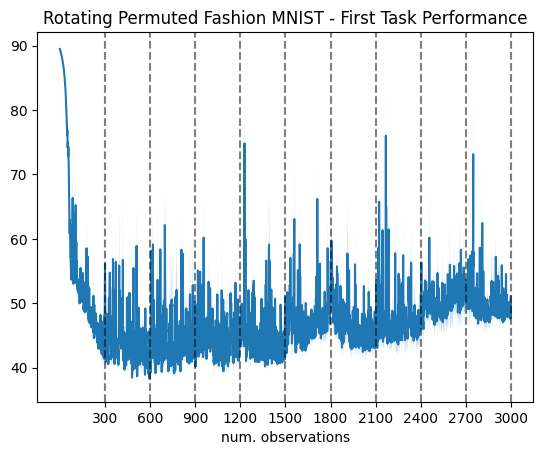

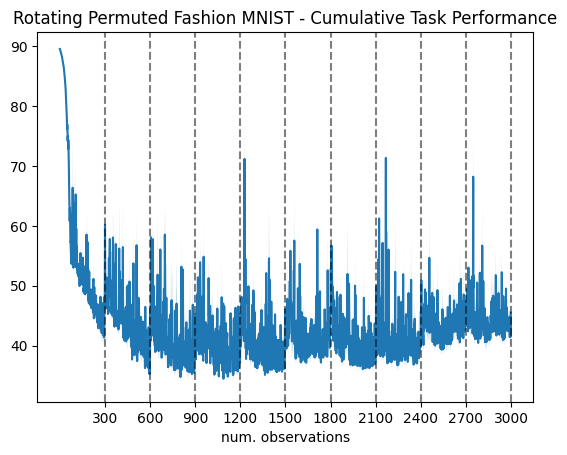

In [ ]:
plot_all_result(nst_300_sgd_1_result, exp_n_iter, "SGD-1", boundaries=nst_300_boundaries)

## 2.2 OGD (Adam)

In [ ]:
nst_300_adam_1_agent = {
    'loss_fn': rmse_loss,
    'buffer_size': 1,
    'dim_output': 1,
    "optimizer": "adam",
}

In [ ]:
nst_300_adam_1_result = optimize_agent("sgd-rb-1", nst_300_adam_1_agent, sgd_pbounds, 
                                       init_points, n_iter, exp_n_iter, nst_300_config)

|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -48.11    | -3.609    |
| 2         | -48.88    | -2.278    |
| 3         | -49.54    | -3.178    |
| 4         | -45.6     | -3.641    |
| 5         | -45.76    | -4.611    |
| 6         | -47.94    | -2.833    |
| 7         | -45.93    | -4.499    |
| 8         | -79.82    | -0.8658   |
| 9         | -208.9    | -0.2907   |
| 10        | -45.54    | -4.932    |
| 11        | -44.2     | -6.413    |
| 12        | -44.85    | -7.599    |
| 13        | -56.41    | -1.537    |
| 14        | -44.64    | -5.724    |
| 15        | -44.62    | -7.018    |
| 16        | -46.13    | -8.0      |
| 17        | -46.33    | -4.042    |
| 18        | -45.05    | -5.724    |
| 19        | -44.91    | -5.72     |
| 20        | -44.3     | -6.419    |
| 21        | -44.0     | -7.023    |
| 22        | -45.23    | -7.605    |
| 23        | -43.38    | -7.029    |
| 24        | -44.56    | -6.407    |
| 25        

Evaluating agent...: 100%|██████████| 5/5 [05:28<00:00, 65.75s/it]


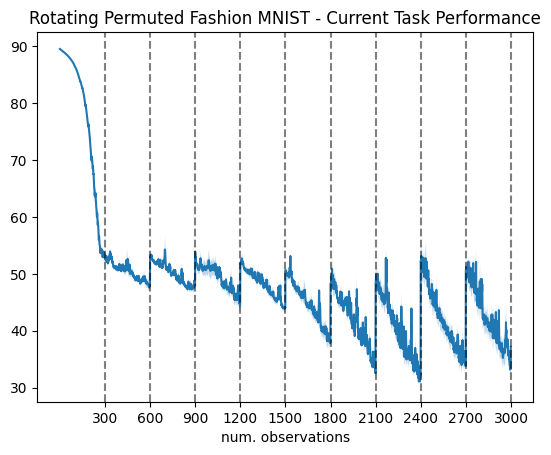

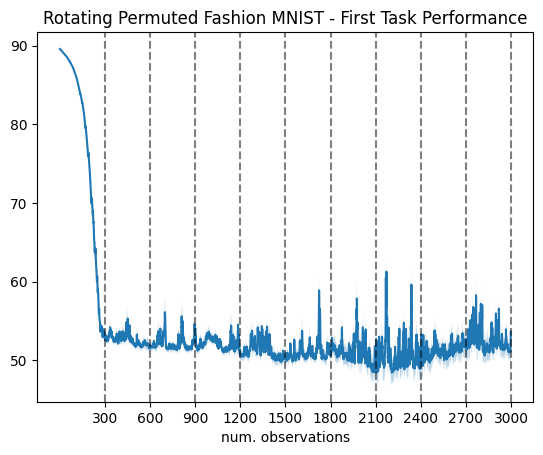

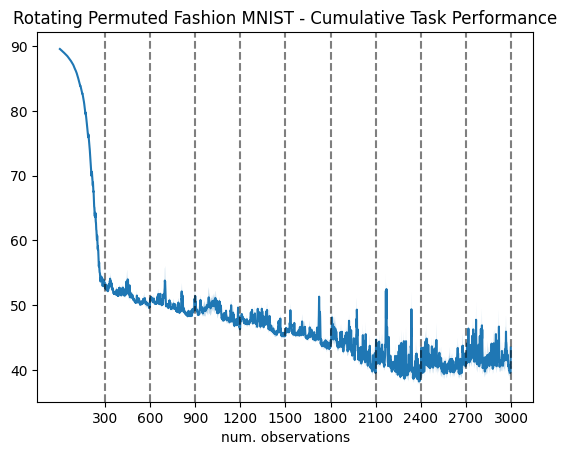

In [ ]:
plot_all_result(nst_300_adam_1_result, exp_n_iter, "Adam-1", boundaries=nst_300_boundaries)

## 2.3. SGD-RB-10 (SGD)

In [ ]:
nst_300_sgd_10_agent = {
    'loss_fn': rmse_loss,
    'buffer_size': 10,
    'dim_output': 1,
    "optimizer": "sgd",
}

In [ ]:
nst_300_sgd_10_result = optimize_agent("sgd-rb-10", nst_300_sgd_10_agent, sgd_pbounds, 
                                       init_points, n_iter, exp_n_iter, nst_300_config)

|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -30.56    | -3.609    |
| 2         | -53.88    | -2.278    |
| 3         | -36.61    | -3.178    |
| 4         | -30.19    | -3.641    |
| 5         | -31.15    | -4.611    |
| 6         | -40.54    | -2.833    |
| 7         | -31.55    | -4.499    |
| 8         | -1e+06    | -0.8658   |
| 9         | -1e+06    | -0.2907   |
| 10        | -31.69    | -4.932    |
| 11        | -58.45    | -8.0      |
| 12        | -38.02    | -6.66     |
| 13        | -33.77    | -5.903    |
| 14        | -49.91    | -7.389    |
| 15        | -32.72    | -5.463    |
| 16        | -42.92    | -7.025    |
| 17        | -45.53    | -2.502    |
| 18        | -35.12    | -6.274    |
| 19        | -55.81    | -7.739    |
| 20        | -30.2     | -4.08     |
| 21        | -32.25    | -5.21     |
| 22        | -32.73    | -5.692    |
| 23        | -36.4     | -6.469    |
| 24        | -29.51    | -3.884    |
| 25        

Evaluating agent...: 100%|██████████| 5/5 [05:31<00:00, 66.27s/it]


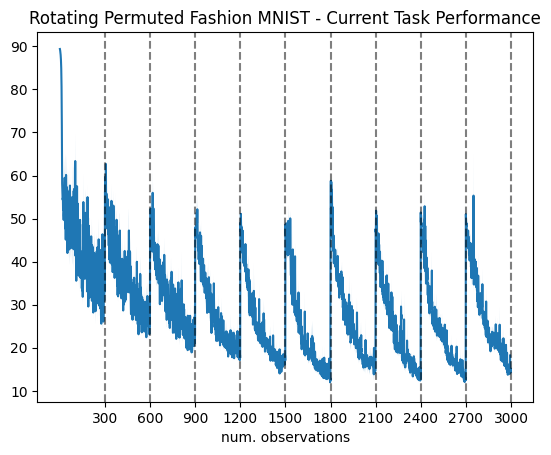

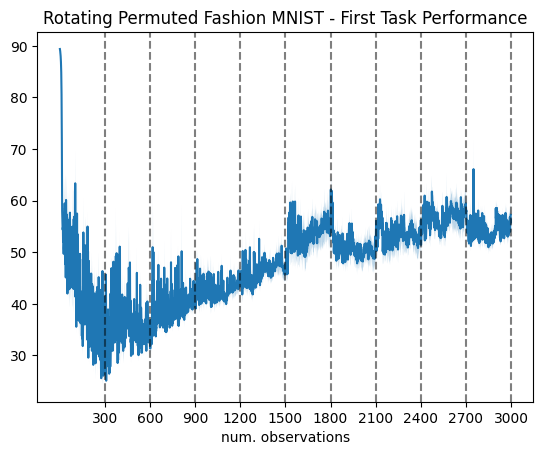

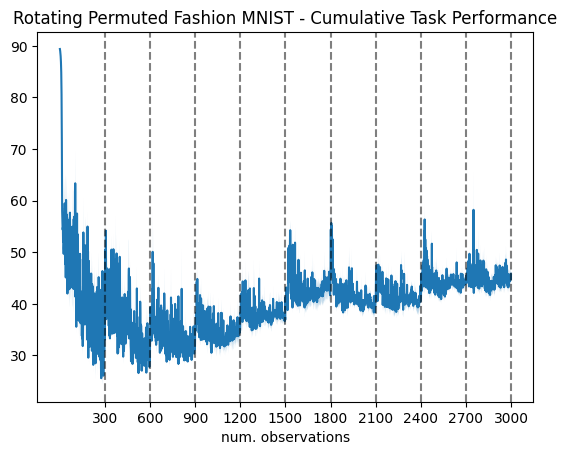

In [ ]:
plot_all_result(nst_300_sgd_10_result, 5, "SGD-10", boundaries=nst_300_boundaries)

## 2.4. SGD-RB-10 (Adam)

In [ ]:
nst_300_adam_10_agent = {
    'loss_fn': rmse_loss,
    'buffer_size': 10,
    'dim_output': 1,
    "optimizer": "adam",
}

In [ ]:
nst_300_adam_10_result = optimize_agent("sgd-rb-10", nst_300_adam_10_agent, sgd_pbounds, 
                                        init_points, n_iter, exp_n_iter, nst_300_config)

|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -40.74    | -3.609    |
| 2         | -46.25    | -2.278    |
| 3         | -42.53    | -3.178    |
| 4         | -38.55    | -3.641    |
| 5         | -36.6     | -4.611    |
| 6         | -45.57    | -2.833    |
| 7         | -37.81    | -4.499    |
| 8         | -62.46    | -0.8658   |
| 9         | -128.5    | -0.2907   |
| 10        | -34.6     | -4.932    |
| 11        | -34.65    | -6.003    |
| 12        | -35.53    | -6.935    |
| 13        | -36.44    | -7.916    |
| 14        | -49.04    | -1.553    |
| 15        | -34.77    | -5.499    |
| 16        | -35.83    | -7.427    |
| 17        | -34.71    | -6.466    |
| 18        | -35.79    | -7.427    |
| 19        | -38.04    | -4.029    |
| 20        | -34.45    | -5.226    |
| 21        | -36.09    | -7.678    |
| 22        | -35.59    | -5.762    |
| 23        | -35.25    | -6.697    |
| 24        | -34.95    | -6.232    |
| 25        

Evaluating agent...: 100%|██████████| 5/5 [05:28<00:00, 65.76s/it]


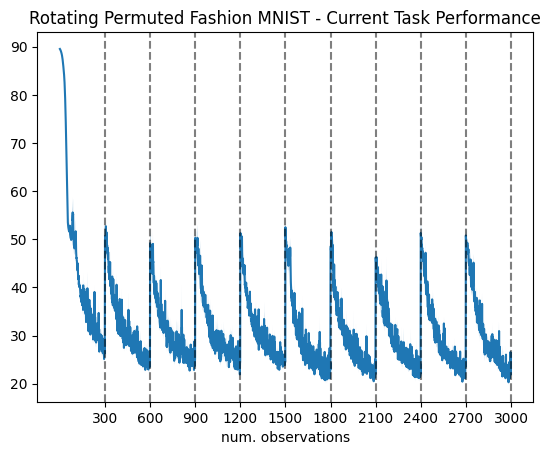

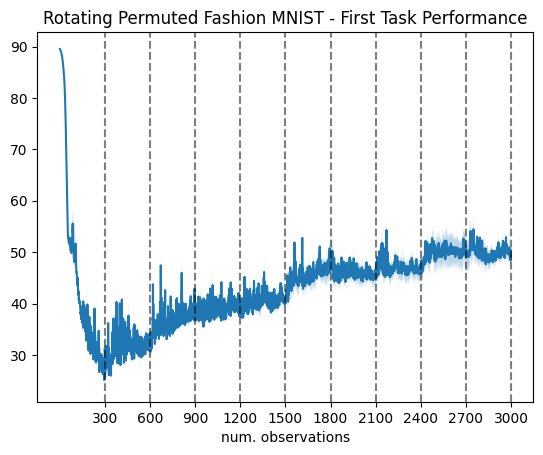

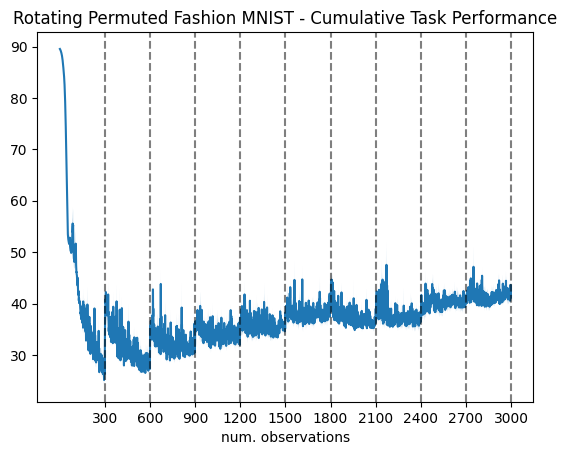

In [ ]:
plot_all_result(nst_300_adam_10_result, 5, "Adam-10", boundaries=nst_300_boundaries)

## 2.5 LOFI-10 (Diagonal)

In [ ]:
lofi_10_diag_agent = {
    'memory_size': 10,
    'inflation': "hybrid",
    "lofi_method": "diagonal",
}

In [ ]:
lofi_pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-40, 0),
    'log_dynamics_cov': (-40, 0),
    'log_emission_cov': (-40, 0),
    'log_alpha': (-40, 0),
}

In [ ]:
lofi_init_points, lofi_n_iter = 10, 15
exp_n_iter = 5

In [ ]:
nst_300_lofi_10_result = optimize_agent("lofi", lofi_10_diag_agent, lofi_pbounds,
                                        lofi_init_points, lofi_n_iter, exp_n_iter, 
                                        nst_300_config)
                                        

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------------------
| 1         | -1e+08    | -18.05    | -11.39    | -15.89    | -18.2     | -5.763    |
| 2         | -85.81    | -14.16    | -22.5     | -4.329    | -1.453    | -6.166    |
| 3         | -29.28    | -8.331    | -18.84    | -17.28    | -2.976    | -9.29     |
| 4         | -1e+08    | -36.51    | -39.19    | -6.695    | -8.874    | -1.3      |
| 5         | -9.98e+07 | -0.8553   | -8.034    | -21.54    | -8.779    | -8.817    |
| 6         | -1e+08    | -14.4     | -34.27    | -2.213    | -19.13    | -5.853    |
| 7         | -9.993e+0 | -29.42    | -9.031    | -21.75    | -17.26    | -9.812    |
| 8         | -32.89    | -15.29    | -15.52    | -15.32    | -2.25     | -3.182    |
| 9         | -1e+08    | -25.62    | -22.52    | -12.09    | -37.59    | -3.332    |
| 10        | -3.184e+1 | -13.17    | -31.58    | -34.

Evaluating agent...: 100%|██████████| 5/5 [07:23<00:00, 88.69s/it]


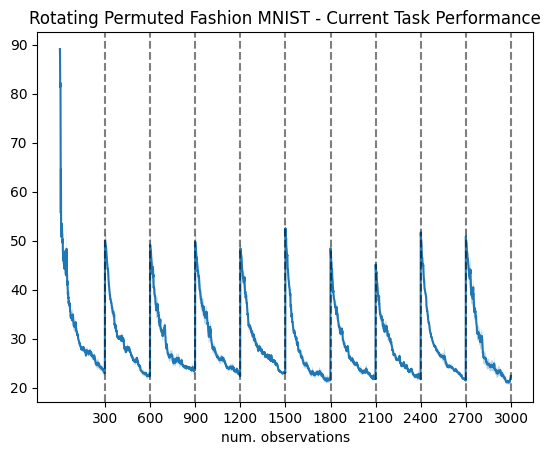

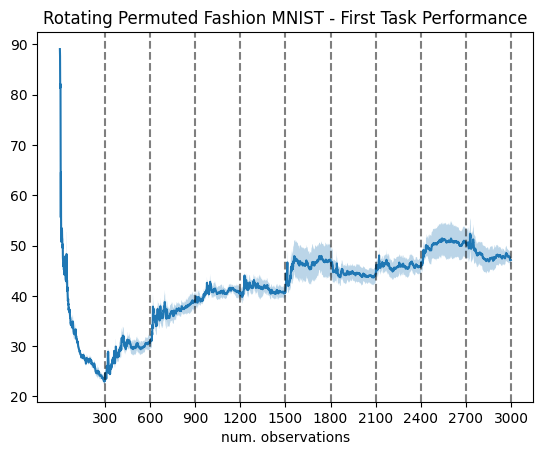

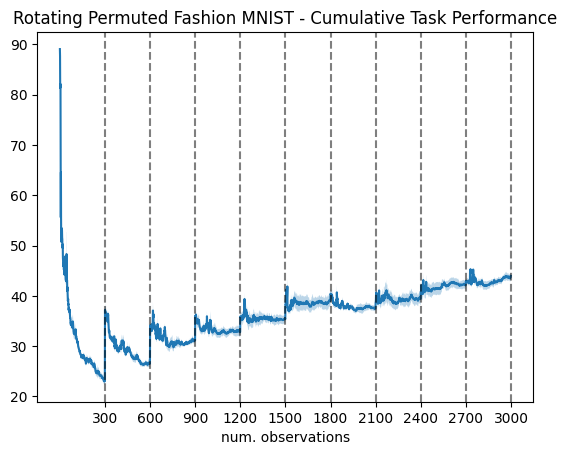

In [ ]:
plot_all_result(nst_300_lofi_10_result, exp_n_iter, "LOFI-Diag-10", boundaries=nst_300_boundaries)

## 2.6 LOFI-10 (Spherical)

In [ ]:
lofi_10_sph_agent = {
    'memory_size': 10,
    'inflation': "hybrid",
    "lofi_method": "spherical",
}

In [ ]:
lofi_init_points, lofi_n_iter = 10, 15
exp_n_iter = 5

In [ ]:
nst_300_lofi_sph_10_result = optimize_agent("lofi", lofi_10_sph_agent, lofi_pbounds,
                                            lofi_init_points, lofi_n_iter, exp_n_iter,
                                            nst_300_config)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------------------
| 1         | -1e+08    | -18.05    | -11.39    | -15.89    | -18.2     | -5.763    |
| 2         | -85.79    | -14.16    | -22.5     | -4.329    | -1.453    | -6.166    |
| 3         | -29.17    | -8.331    | -18.84    | -17.28    | -2.976    | -9.29     |
| 4         | -1.237e+0 | -36.51    | -39.19    | -6.695    | -8.874    | -1.3      |
| 5         | -3.622e+1 | -0.8553   | -8.034    | -21.54    | -8.779    | -8.817    |
| 6         | -1e+08    | -14.4     | -34.27    | -2.213    | -19.13    | -5.853    |
| 7         | -1e+08    | -29.42    | -9.031    | -21.75    | -17.26    | -9.812    |
| 8         | -1.011e+1 | -15.29    | -15.52    | -15.32    | -2.25     | -3.182    |
| 9         | -1e+08    | -25.62    | -22.52    | -12.09    | -37.59    | -3.332    |
| 10        | -1e+08    | -13.17    | -31.58    | -34.

Evaluating agent...: 100%|██████████| 5/5 [06:07<00:00, 73.53s/it]


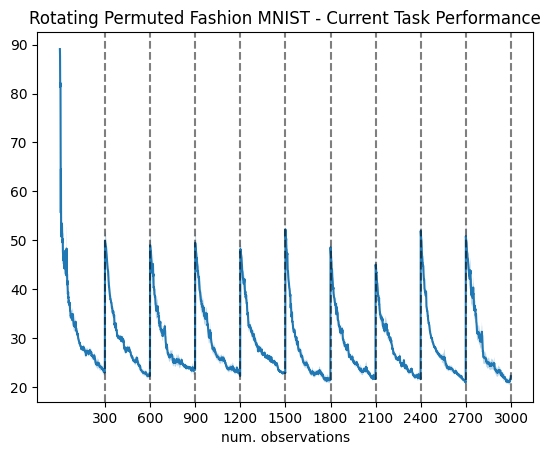

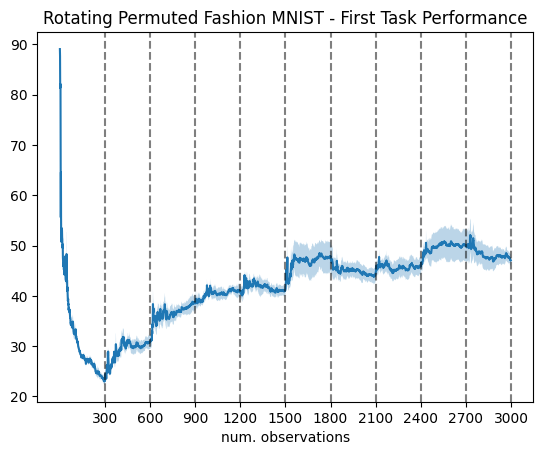

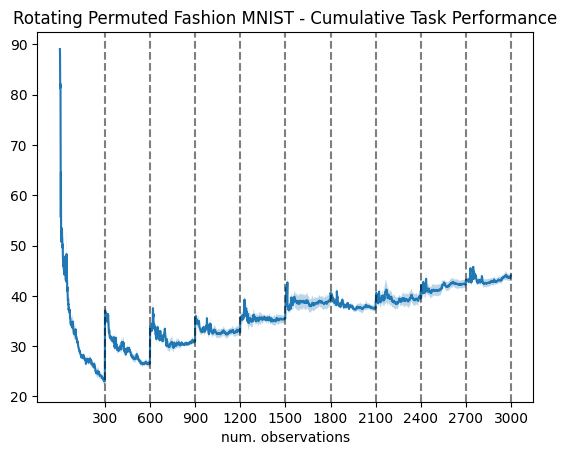

In [ ]:
plot_all_result(nst_300_lofi_sph_10_result, exp_n_iter, "LOFI-Sph-10", boundaries=nst_300_boundaries)

## 2.7 Comparison

In [ ]:
results = {
    "SGD-RB-10": nst_300_sgd_10_result,
    "ADAM-RB-10": nst_300_adam_10_result,
    "LOFI-10": nst_300_lofi_10_result,
    "LOFI-10-SPH": nst_300_lofi_sph_10_result,
}

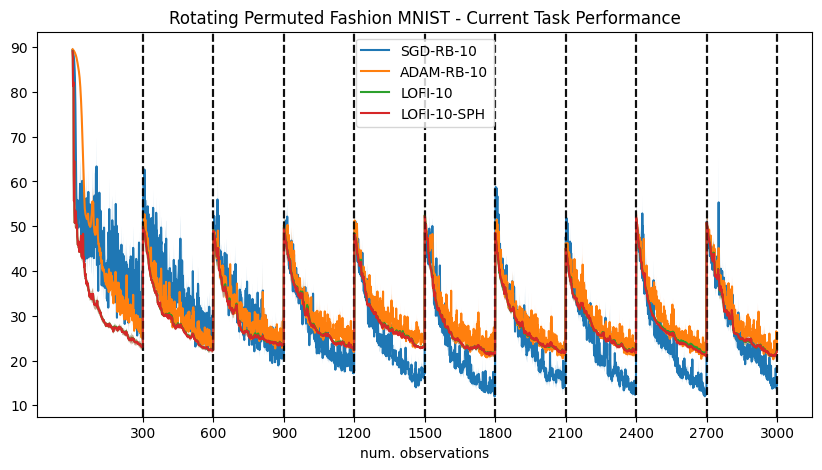

In [ ]:
# Current task result
fig, ax = plt.subplots(figsize=(10, 5))
for key, val in results.items():
    mean, std = val["current"], val["current-std"]
    plot_result(
        mean, std, exp_n_iter, label=key, boundaries=nst_300_boundaries, ax=ax,
        title="Rotating Permuted Fashion MNIST - Current Task Performance"
    )
ax.legend();

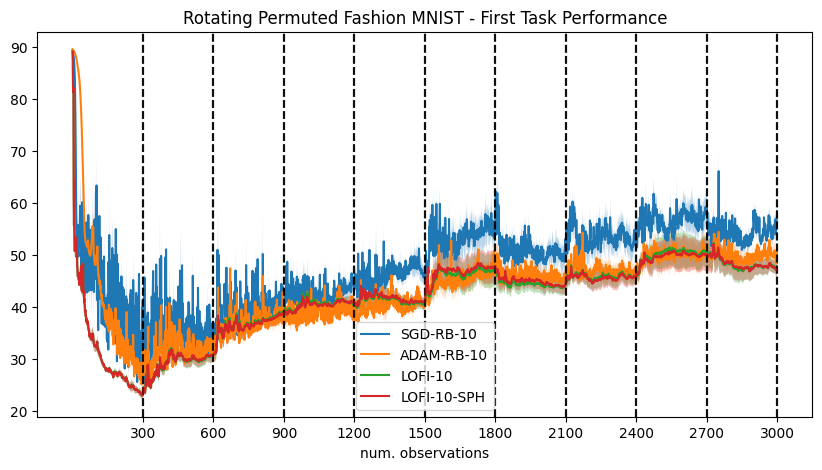

In [ ]:
# First task result
fig, ax = plt.subplots(figsize=(10, 5))
for key, val in results.items():
    mean, std = val["first_task"], val["first_task-std"]
    plot_result(
        mean, std, exp_n_iter, label=key, boundaries=nst_300_boundaries, ax=ax,
        title="Rotating Permuted Fashion MNIST - First Task Performance"
    )
ax.legend();

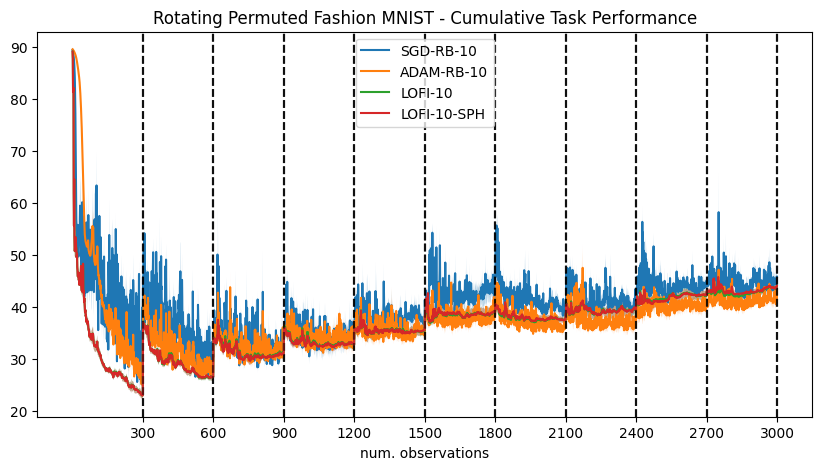

In [ ]:
# Cumulative task result
fig, ax = plt.subplots(figsize=(10, 5))
for key, val in results.items():
    mean, std = val["overall"], val["overall-std"]
    plot_result(
        mean, std, exp_n_iter, label=key, boundaries=nst_300_boundaries, ax=ax,
        title="Rotating Permuted Fashion MNIST - Cumulative Task Performance"
    )
ax.legend();

# 3. Nonstationary Regression (1,000 per task)

## 3.0 Dataset

In [ ]:
nst_1000_data_kwargs = {
    'n_tasks': 10,
    'ntrain_per_task': 1_000,
    'nval_per_task': 1,
    'ntest_per_task': 1_000,
}
nst_1000_dataset = \
    data_utils.generate_rotating_permuted_mnist_regression_dataset(**nst_1000_data_kwargs)
nst_1000_dataset_load_fn = partial(data_utils.generate_rotating_permuted_mnist_regression_dataset, 
                                  **nst_1000_data_kwargs, fashion=True)

2023-04-28 02:08:27.402992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-04-28 02:08:27.403033: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
nt_1000, npt_1000 = nst_1000_data_kwargs["n_tasks"], nst_1000_data_kwargs["ntrain_per_task"]

nst_1000_boundaries = [i for i in range(npt_1000, (npt_1000*nt_1000)+1, npt_1000)]

In [ ]:
nst_1000_config = {
    "dataset": nst_1000_dataset,
    "data_load_fn": nst_1000_dataset_load_fn,
    "ntrain_per_task": nst_1000_data_kwargs['ntrain_per_task'],
    "ntest_per_task": nst_1000_data_kwargs['ntest_per_task'],
}

## 3.1 OGD 

In [ ]:
nst_1000_sgd_1_result = optimize_agent("sgd-rb-1", nst_300_sgd_1_agent, sgd_pbounds, 
                                       init_points, n_iter, exp_n_iter, nst_1000_config)

|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -50.64    | -3.609    |
| 2         | -69.91    | -2.278    |
| 3         | -50.92    | -3.178    |
| 4         | -50.16    | -3.641    |
| 5         | -33.86    | -4.611    |
| 6         | -50.65    | -2.833    |
| 7         | -35.19    | -4.499    |
| 8         | -1e+06    | -0.8658   |
| 9         | -1e+06    | -0.2907   |
| 10        | -31.81    | -4.932    |
| 11        | -41.02    | -8.0      |
| 12        | -30.83    | -6.66     |
| 13        | -30.53    | -5.903    |
| 14        | -34.37    | -7.389    |
| 15        | -30.88    | -5.463    |
| 16        | -31.85    | -7.025    |
| 17        | -222.6    | -2.502    |
| 18        | -30.33    | -6.274    |
| 19        | -37.7     | -7.739    |
| 20        | -41.26    | -4.08     |
| 21        | -30.96    | -5.21     |
| 22        | -30.71    | -5.692    |
| 23        | -30.61    | -6.469    |
| 24        | -45.63    | -3.884    |
| 25        

Evaluating agent...: 100%|██████████| 5/5 [06:54<00:00, 82.95s/it]


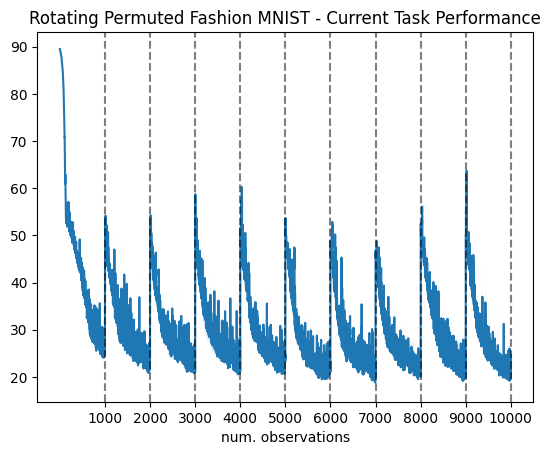

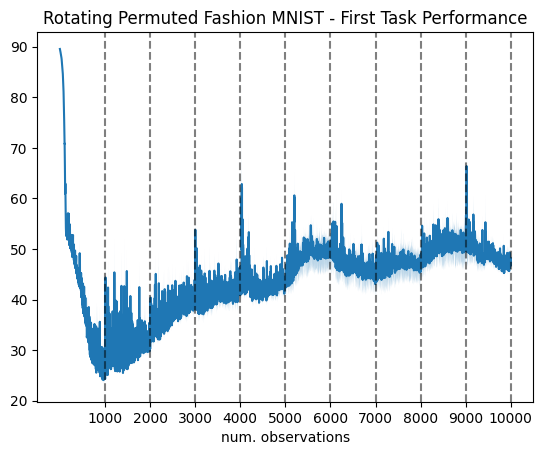

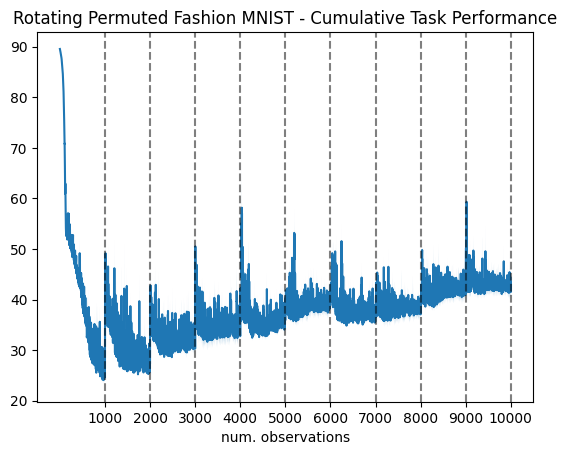

In [ ]:
plot_all_result(nst_1000_sgd_1_result, exp_n_iter, "OGD", boundaries=nst_1000_boundaries)

## 3.2 SGD-RB-10

In [24]:
nst_1000_sgd_10_result = optimize_agent("sgd-rb-10", nst_300_sgd_10_agent, sgd_pbounds, 
                                        init_points, n_iter, exp_n_iter, nst_1000_config)

|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -17.83    | -3.609    |
| 2         | -46.93    | -2.278    |
| 3         | -25.33    | -3.178    |
| 4         | -18.19    | -3.641    |
| 5         | -17.28    | -4.611    |
| 6         | -35.37    | -2.833    |
| 7         | -16.94    | -4.499    |
| 8         | -1e+06    | -0.8658   |
| 9         | -1e+06    | -0.2907   |
| 10        | -18.61    | -4.932    |
| 11        | -37.22    | -8.0      |
| 12        | -25.55    | -6.66     |
| 13        | -23.58    | -5.903    |
| 14        | -29.75    | -7.389    |
| 15        | -21.25    | -5.463    |
| 16        | -27.24    | -7.025    |
| 17        | -38.8     | -2.502    |
| 18        | -24.43    | -6.274    |
| 19        | -33.45    | -7.739    |
| 20        | -16.28    | -4.08     |
| 21        | -19.76    | -5.21     |
| 22        | -22.41    | -5.692    |
| 23        | -24.95    | -6.469    |
| 24        | -16.56    | -3.884    |
| 25        

Evaluating agent...: 100%|██████████| 5/5 [06:58<00:00, 83.80s/it]


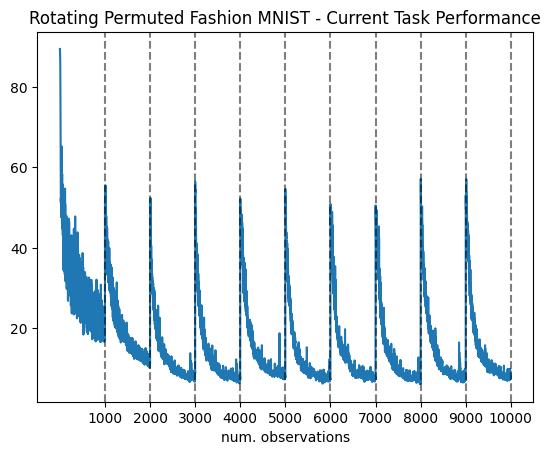

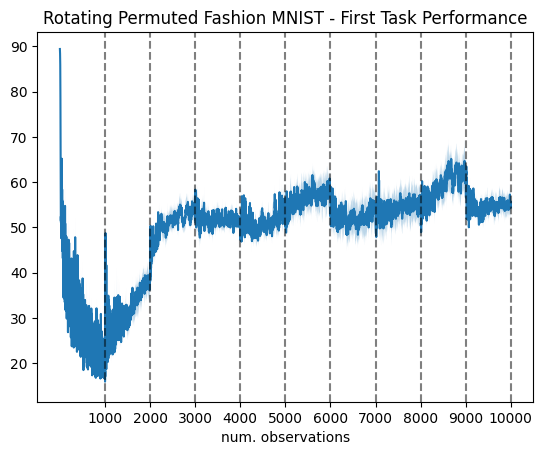

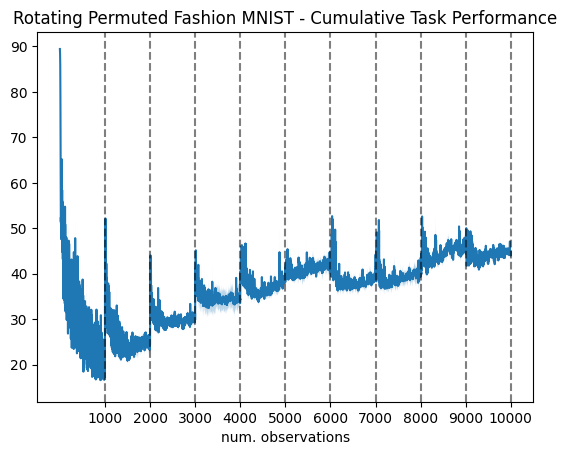

In [25]:
plot_all_result(nst_1000_sgd_10_result, exp_n_iter, "SGD-10", boundaries=nst_1000_boundaries)

## 3.3 LOFI-10 (Diagonal)

In [26]:
nst_1000_lofi_10_result = optimize_agent("lofi", lofi_10_diag_agent, lofi_pbounds,
                                         lofi_init_points, lofi_n_iter, exp_n_iter, 
                                         nst_1000_config)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------------------
| 1         | -1e+08    | -18.05    | -11.39    | -15.89    | -18.2     | -5.763    |
| 2         | -89.48    | -14.16    | -22.5     | -4.329    | -1.453    | -6.166    |
| 3         | -21.29    | -8.331    | -18.84    | -17.28    | -2.976    | -9.29     |
| 4         | -1e+08    | -36.51    | -39.19    | -6.695    | -8.874    | -1.3      |
| 5         | -9.997e+0 | -0.8553   | -8.034    | -21.54    | -8.779    | -8.817    |
| 6         | -1e+08    | -14.4     | -34.27    | -2.213    | -19.13    | -5.853    |
| 7         | -9.998e+0 | -29.42    | -9.031    | -21.75    | -17.26    | -9.812    |
| 8         | -1e+08    | -15.29    | -15.52    | -15.32    | -2.25     | -3.182    |
| 9         | -1e+08    | -25.62    | -22.52    | -12.09    | -37.59    | -3.332    |
| 10        | -1e+08    | -13.17    | -31.58    | -34.

Evaluating agent...: 100%|██████████| 5/5 [09:08<00:00, 109.62s/it]


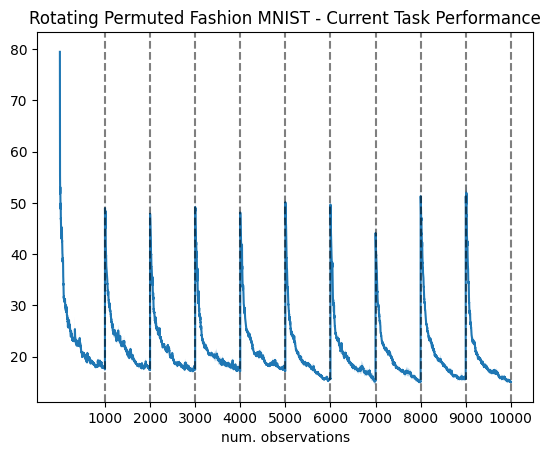

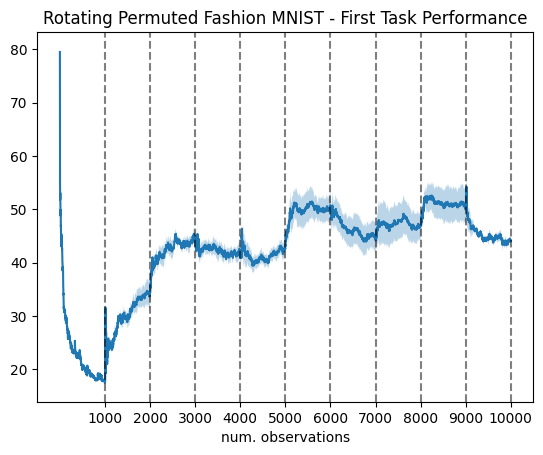

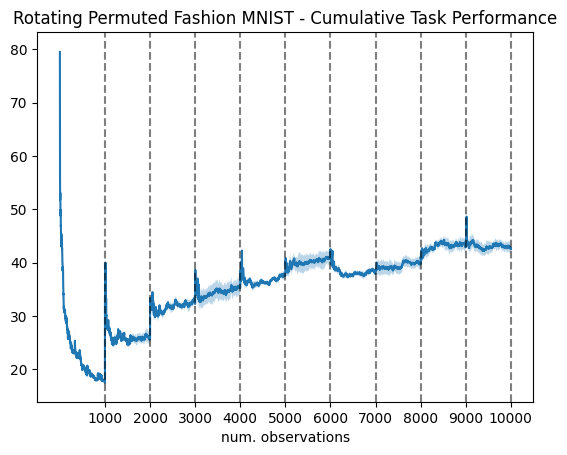

In [27]:
plot_all_result(nst_1000_lofi_10_result, exp_n_iter, "LOFI-Diag-10", boundaries=nst_1000_boundaries)

## 3.4 LOFI-10 (Spherical)

In [28]:
nst_1000_lofi_sph_10_result = optimize_agent("lofi", lofi_10_sph_agent, lofi_pbounds,
                                             lofi_init_points, lofi_n_iter, exp_n_iter,
                                             nst_1000_config)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------------------
| 1         | -1e+08    | -18.05    | -11.39    | -15.89    | -18.2     | -5.763    |
| 2         | -89.46    | -14.16    | -22.5     | -4.329    | -1.453    | -6.166    |
| 3         | -21.28    | -8.331    | -18.84    | -17.28    | -2.976    | -9.29     |
| 4         | -1.115e+0 | -36.51    | -39.19    | -6.695    | -8.874    | -1.3      |
| 5         | -1e+08    | -0.8553   | -8.034    | -21.54    | -8.779    | -8.817    |
| 6         | -1e+08    | -14.4     | -34.27    | -2.213    | -19.13    | -5.853    |
| 7         | -1e+08    | -29.42    | -9.031    | -21.75    | -17.26    | -9.812    |
| 8         | -1.117e+0 | -15.29    | -15.52    | -15.32    | -2.25     | -3.182    |
| 9         | -1e+08    | -25.62    | -22.52    | -12.09    | -37.59    | -3.332    |
| 10        | -1e+08    | -13.17    | -31.58    | -34.

Evaluating agent...: 100%|██████████| 5/5 [07:43<00:00, 92.76s/it]


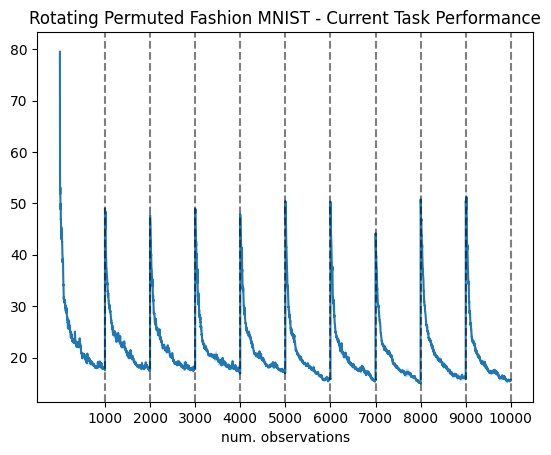

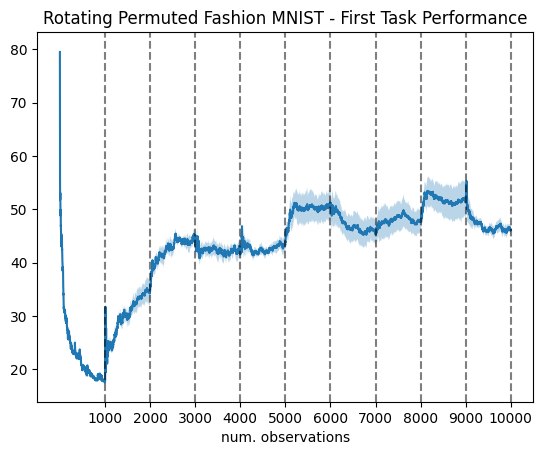

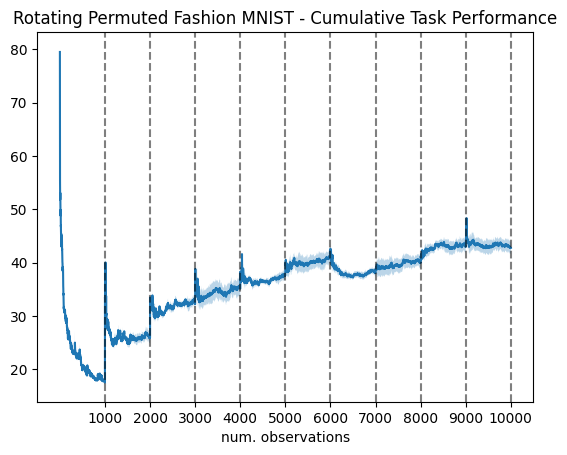

In [29]:
plot_all_result(nst_1000_lofi_sph_10_result, exp_n_iter, "LOFI-Sph-10", boundaries=nst_1000_boundaries)

## 3.5 Model Comparison

In [56]:
# Load results from pickle
output_path = Path(Path().cwd(), "results", "non_stationary_reg_1000")
nst_1000_sgd_1_result = {
    "current": pickle.load(open(Path(output_path, "OGD_current_mean.pkl"), "rb")),
    "current-std": pickle.load(open(Path(output_path, "OGD_current_std.pkl"), "rb")),
    "first_task": pickle.load(open(Path(output_path, "OGD_first_task_mean.pkl"), "rb")),
    "first_task-std": pickle.load(open(Path(output_path, "OGD_first_task_std.pkl"), "rb")),
    "overall": pickle.load(open(Path(output_path, "OGD_overall_mean.pkl"), "rb")),
    "overall-std": pickle.load(open(Path(output_path, "OGD_overall_std.pkl"), "rb")),
}

nst_1000_sgd_10_result = {
    "current": pickle.load(open(Path(output_path, "SGD-RB-10_current_mean.pkl"), "rb")),
    "current-std": pickle.load(open(Path(output_path, "SGD-RB-10_current_std.pkl"), "rb")),
    "first_task": pickle.load(open(Path(output_path, "SGD-RB-10_first_task_mean.pkl"), "rb")),
    "first_task-std": pickle.load(open(Path(output_path, "SGD-RB-10_first_task_std.pkl"), "rb")),
    "overall": pickle.load(open(Path(output_path, "SGD-RB-10_overall_mean.pkl"), "rb")),
    "overall-std": pickle.load(open(Path(output_path, "SGD-RB-10_overall_std.pkl"), "rb")),
}

nst_1000_lofi_10_result = {
    "current": pickle.load(open(Path(output_path, "LOFI-10_current_mean.pkl"), "rb")),
    "current-std": pickle.load(open(Path(output_path, "LOFI-10_current_std.pkl"), "rb")),
    "first_task": pickle.load(open(Path(output_path, "LOFI-10_first_task_mean.pkl"), "rb")),
    "first_task-std": pickle.load(open(Path(output_path, "LOFI-10_first_task_std.pkl"), "rb")),
    "overall": pickle.load(open(Path(output_path, "LOFI-10_overall_mean.pkl"), "rb")),
    "overall-std": pickle.load(open(Path(output_path, "LOFI-10_overall_std.pkl"), "rb")),
}

nst_1000_lofi_sph_10_result = {
    "current": pickle.load(open(Path(output_path, "LOFI-10-SPH_current_mean.pkl"), "rb")),
    "current-std": pickle.load(open(Path(output_path, "LOFI-10-SPH_current_std.pkl"), "rb")),
    "first_task": pickle.load(open(Path(output_path, "LOFI-10-SPH_first_task_mean.pkl"), "rb")),
    "first_task-std": pickle.load(open(Path(output_path, "LOFI-10-SPH_first_task_std.pkl"), "rb")),
    "overall": pickle.load(open(Path(output_path, "LOFI-10-SPH_overall_mean.pkl"), "rb")),
    "overall-std": pickle.load(open(Path(output_path, "LOFI-10-SPH_overall_std.pkl"), "rb")),
}

In [57]:
nst_1000_results = {
    "OGD": nst_1000_sgd_1_result,
    "SGD-RB-10": nst_1000_sgd_10_result,
    "LOFI-10": nst_1000_lofi_10_result,
    "LOFI-10-SPH": nst_1000_lofi_sph_10_result,
}

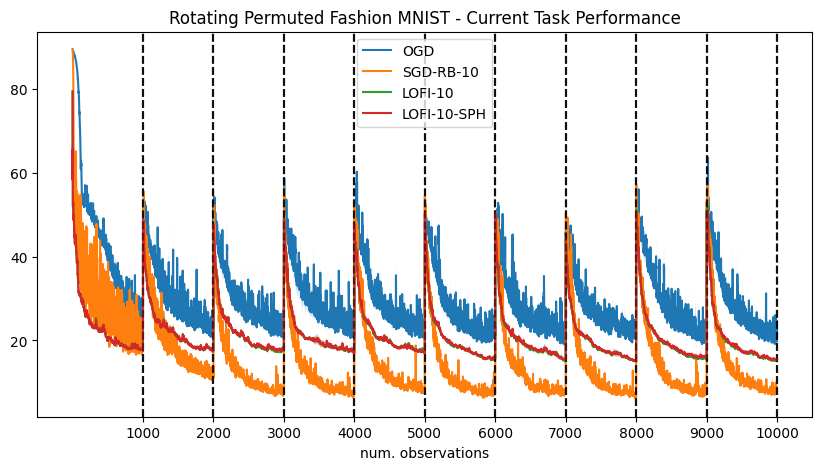

In [58]:
# Current task result
fig, ax = plt.subplots(figsize=(10, 5))
for key, val in nst_1000_results.items():
    mean, std = val["current"], val["current-std"]
    plot_result(
        mean, std, exp_n_iter, label=key, boundaries=nst_1000_boundaries, ax=ax,
        title="Rotating Permuted Fashion MNIST - Current Task Performance"
    )
ax.legend();

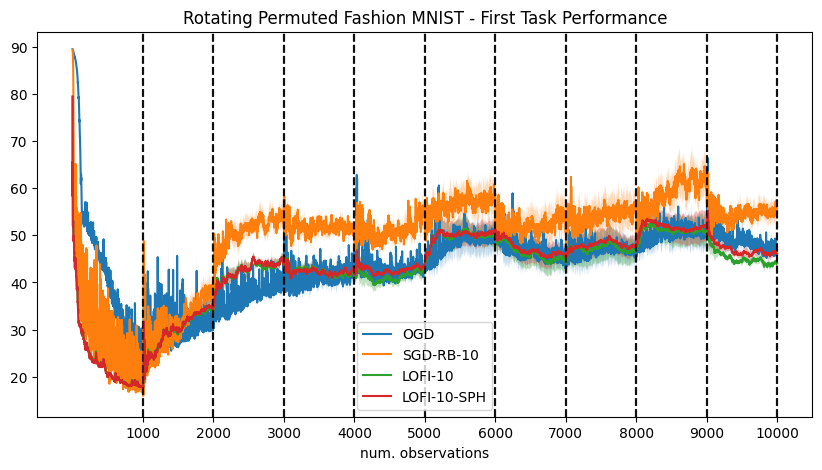

In [59]:
# First task result
fig, ax = plt.subplots(figsize=(10, 5))
for key, val in nst_1000_results.items():
    mean, std = val["first_task"], val["first_task-std"]
    plot_result(
        mean, std, exp_n_iter, label=key, boundaries=nst_1000_boundaries, ax=ax,
        title="Rotating Permuted Fashion MNIST - First Task Performance"
    )
ax.legend();

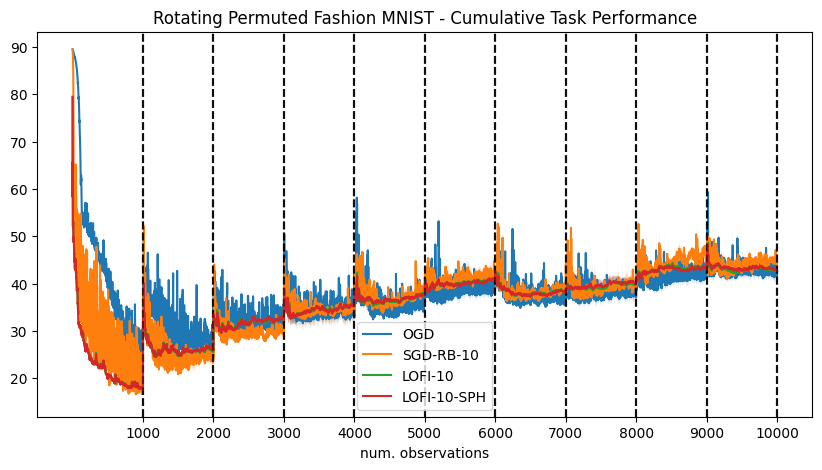

In [60]:
# Cumulative task result
fig, ax = plt.subplots(figsize=(10, 5))
for key, val in nst_1000_results.items():
    mean, std = val["overall"], val["overall-std"]
    plot_result(
        mean, std, exp_n_iter, label=key, boundaries=nst_1000_boundaries, ax=ax,
        title="Rotating Permuted Fashion MNIST - Cumulative Task Performance"
    )
ax.legend();

In [54]:
# # Save results to pickle
# output_path = Path(Path().cwd(), "results", "non_stationary_reg_1000")
# output_path.mkdir(parents=True, exist_ok=True)

# for k, v in nst_1000_results.items():
#     curr_mean, curr_std = v["current"], v["current-std"]
#     with open(Path(output_path, f"{k}_current_mean.pkl"), "wb") as f:
#         pickle.dump(curr_mean, f)
#     with open(Path(output_path, f"{k}_current_std.pkl"), "wb") as f:
#         pickle.dump(curr_std, f)
    
#     task1_mean, task1_std = v["first_task"], v["first_task-std"]
#     with open(Path(output_path, f"{k}_first_task_mean.pkl"), "wb") as f:
#         pickle.dump(task1_mean, f)
#     with open(Path(output_path, f"{k}_first_task_std.pkl"), "wb") as f:
#         pickle.dump(task1_std, f)
        
#     overall_mean, overall_std = v["overall"], v["overall-std"]
#     with open(Path(output_path, f"{k}_overall_mean.pkl"), "wb") as f:
#         pickle.dump(overall_mean, f)
#     with open(Path(output_path, f"{k}_overall_std.pkl"), "wb") as f:
#         pickle.dump(overall_std, f)